# 01 — Overview (Outbound migration pressure over time)

**Dataset (source file):** `raw_data/hdx_hapi_refugees_afg.csv`  
**Website section:** `js/sections/overview.js`

This notebook:
1) reads the raw file,
2) applies the same filters as the website,
3) saves a **cleaned** dataset to `dataset/cleaned/refugees_outflow_clean.csv`,
4) shows which rows were removed (and why, via the filter mask),
5) produces derived outputs: `dataset/derived/outflow_by_year.csv` and `.json`.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

RAW_DIR = Path("raw_data")        # raw inputs live here
DATASET_DIR = Path("dataset")     # website reads from here
CLEAN_DIR = DATASET_DIR / "cleaned"
DERIVED_DIR = DATASET_DIR / "derived"

CLEAN_DIR.mkdir(parents=True, exist_ok=True)
DERIVED_DIR.mkdir(parents=True, exist_ok=True)

def to_number(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(",", "").str.strip(), errors="coerce")

def parse_year(val) -> float:
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if len(s) >= 4 and s[:4].isdigit():
        return float(s[:4])
    for sep in ("/", "-"):
        parts = s.split(sep)
        if len(parts) == 3 and parts[-1].isdigit():
            return float(parts[-1])
    return np.nan

def show_filter_report(df_before: pd.DataFrame, mask: pd.Series, title: str, sample_n: int = 10):
    kept = df_before[mask].copy()
    dropped = df_before[~mask].copy()
    print(f"=== {title} ===")
    print("rows_before:", len(df_before))
    print("rows_kept:", len(kept))
    print("rows_dropped:", len(dropped))
    if len(dropped):
        print("\nSample dropped rows:")
        display(dropped.head(sample_n))
    return kept, dropped


In [5]:
# raw_path = RAW_DIR / "hdx_hapi_refugees_afg.csv"
# df = pd.read_csv(raw_path)
import pandas as pd

df = pd.read_csv("hdx_hapi_refugees_afg.csv")
df.head()

df.head()


,origin_location_code,origin_has_hrp,origin_in_gho,asylum_location_code,asylum_has_hrp,asylum_in_gho,population_group,gender,age_range,min_age,max_age,population,reference_period_start,reference_period_end
0,AFG,True,True,AFG,True,True,OOC,f,0-4,0.0,4.0,8751,2020-01-01,2020-12-31
1,AFG,True,True,AFG,True,True,OOC,f,5-11,5.0,11.0,8775,2020-01-01,2020-12-31
2,AFG,True,True,AFG,True,True,OOC,f,12-17,12.0,17.0,5828,2020-01-01,2020-12-31
3,AFG,True,True,AFG,True,True,OOC,f,18-59,18.0,59.0,18958,2020-01-01,2020-12-31
4,AFG,True,True,AFG,True,True,OOC,f,60+,60.0,NaN,587,2020-01-01,2020-12-31


In [7]:
required = {"origin_location_code","asylum_location_code","reference_period_start","population"}
missing = sorted(required - set(df.columns))
assert not missing, f"Missing columns: {missing}"

df2 = df.copy()
df2["year"] = df2["reference_period_start"].apply(parse_year)
df2["population_num"] = to_number(df2["population"])

mask = (df2["origin_location_code"].astype(str).str.strip() == "AFG") &        (df2["asylum_location_code"].astype(str).str.strip() != "AFG") &        (df2["year"].notna()) &        (df2["population_num"].notna()) &        (df2["population_num"] > 0)

if "population_group" in df2.columns:
    g = df2["population_group"].astype(str).str.strip().str.upper()
    mask = mask & ((g == "") | (g.isin(["REF","ASY"])))

kept, dropped = show_filter_report(df2, mask, "Refugees/outflow filter (AFG origin, dest != AFG, valid year, pop>0, group REF/ASY)")


=== Refugees/outflow filter (AFG origin, dest != AFG, valid year, pop>0, group REF/ASY) ===
rows_before: 43927
rows_kept: 14602
rows_dropped: 29325

Sample dropped rows:


,origin_location_code,origin_has_hrp,origin_in_gho,asylum_location_code,asylum_has_hrp,asylum_in_gho,population_group,gender,age_range,min_age,max_age,population,reference_period_start,reference_period_end,year,population_num
0,AFG,True,True,AFG,True,True,OOC,f,0-4,0.0,4.0,8751,2020-01-01,2020-12-31,2020.0,8751
1,AFG,True,True,AFG,True,True,OOC,f,5-11,5.0,11.0,8775,2020-01-01,2020-12-31,2020.0,8775
2,AFG,True,True,AFG,True,True,OOC,f,12-17,12.0,17.0,5828,2020-01-01,2020-12-31,2020.0,5828
3,AFG,True,True,AFG,True,True,OOC,f,18-59,18.0,59.0,18958,2020-01-01,2020-12-31,2020.0,18958
4,AFG,True,True,AFG,True,True,OOC,f,60+,60.0,NaN,587,2020-01-01,2020-12-31,2020.0,587
5,AFG,True,True,AFG,True,True,OOC,f,all,NaN,NaN,42899,2020-01-01,2020-12-31,2020.0,42899
6,AFG,True,True,AFG,True,True,OOC,m,0-4,0.0,4.0,8814,2020-01-01,2020-12-31,2020.0,8814
7,AFG,True,True,AFG,True,True,OOC,m,5-11,5.0,11.0,5017,2020-01-01,2020-12-31,2020.0,5017
8,AFG,True,True,AFG,True,True,OOC,m,12-17,12.0,17.0,4785,2020-01-01,2020-12-31,2020.0,4785
9,AFG,True,True,AFG,True,True,OOC,m,18-59,18.0,59.0,19273,2020-01-01,2020-12-31,2020.0,19273


In [9]:
# Save cleaned (only fields used for the outflow story)
clean = kept.copy()
clean["year"] = clean["year"].astype(int)
clean["population_num"] = clean["population_num"].fillna(0).astype(float)

clean_out = CLEAN_DIR / "refugees_outflow_clean.csv"
clean.to_csv(clean_out, index=False)
clean_out


WindowsPath('dataset/cleaned/refugees_outflow_clean.csv')

In [11]:
# Aggregate outflow by year (same as overview.js)
outflow = (clean.groupby("year", as_index=False)["population_num"].sum()
             .sort_values("year"))
outflow.rename(columns={"population_num":"outflow_ref_asy"}, inplace=True)
outflow.head(), outflow.tail()


(   year  outflow_ref_asy
 0  2001        9894718.0
 1  2002        5045427.0
 2  2003        6115659.0
 3  2004        6297914.0
 4  2005        5146101.0,
     year  outflow_ref_asy
 19  2020        6491529.0
 20  2021        8232789.0
 21  2022       16978720.0
 22  2023       19016818.0
 23  2024       17829950.0)

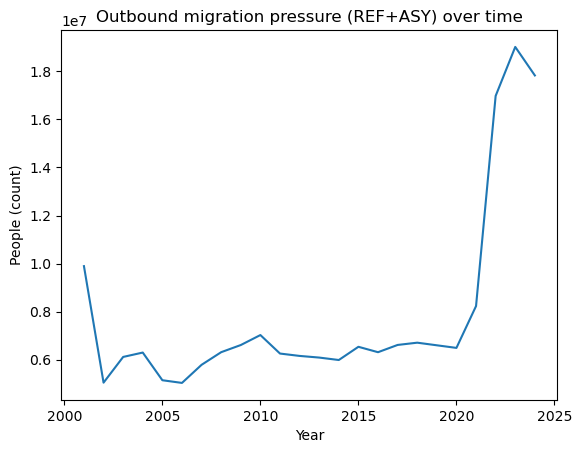

In [13]:
plt.figure()
plt.plot(outflow["year"], outflow["outflow_ref_asy"])
plt.title("Outbound migration pressure (REF+ASY) over time")
plt.xlabel("Year")
plt.ylabel("People (count)")
plt.show()


In [19]:
out_csv = DERIVED_DIR / "outflow_by_year.csv"
out_json = DERIVED_DIR / "outflow_by_year.json"
outflow.to_csv(out_csv, index=False)
outflow.set_index("year")["outflow_ref_asy"].to_json(out_json, indent=2)
(out_csv, out_json)


(WindowsPath('dataset/derived/outflow_by_year.csv'),
 WindowsPath('dataset/derived/outflow_by_year.json'))

In [21]:
# Optional: save dropped rows for auditing
dropped_out = CLEAN_DIR / "refugees_outflow_dropped.csv"
dropped.to_csv(dropped_out, index=False)
dropped_out


WindowsPath('dataset/cleaned/refugees_outflow_dropped.csv')